In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import LSTM_Train as LSTM

%matplotlib inline
%config IPCompleter.greedy=True
plt.rcParams["figure.figsize"] = (14, 8)

    N  T  MSE  STD
0  45  4  0.0  0.0
1  84  7  0.0  0.0
2  97  4  0.0  0.0
3  87  7  0.0  0.0
4  80  7  0.0  0.0
5  61  6  0.0  0.0
{'T_Max': 10, 'N_Max': 100, 'reps': 1, 'epochs': 20, 'Y': 'fch4', 'proc': 1, 'Searches': 2}


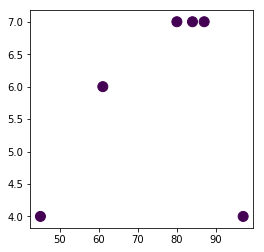

In [2]:
class Params:
    def __init__(self,Func,Y):
        if Func == 'Full':
            epochs = 1000
            reps = 50
            N_Max = 200
            T_Max = 48
            samp_size = 20
            Searches = 10
        else:
            epochs = 20
            reps = 2
            N_Max = 100
            N_min = 2
            T_Max = 10
            samp_size = 6
            Searches = 2
        N = np.array(np.random.rand(samp_size)*N_Max+N_min,dtype='int32')
        T = np.array(np.random.rand(samp_size)*T_Max,dtype='int32')
        d = {'N':N,'T':T}
        self.Runs = pd.DataFrame(data=d)
        self.params = {}
        self.params['T_Max'] = T_Max
        self.params['N_Max'] = N_Max
        self.params['reps'] = reps
        self.params['epochs'] = epochs
        self.params['Y'] = Y
        self.params['proc']=1
        self.params['Searches']=Searches

rpms = Params('Test','fch4')
# rpms = Params('Test',5,'ch4_flux')
Runs,params = rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
print(Runs)
print(params)
plt.figure(figsize = (4,4))
plt.scatter(Runs["N"],Runs['T'],s=100,c=Runs['MSE'])

Using TensorFlow backend.


Finisehed Run  0
 Stats: 
Finisehed Run  1
 Stats: 
Finisehed Run  2
 Stats: 
Finisehed Run  3
 Stats: 
Finisehed Run  4
 Stats: 
Finisehed Run  5
 Stats: 
67.55784010887146


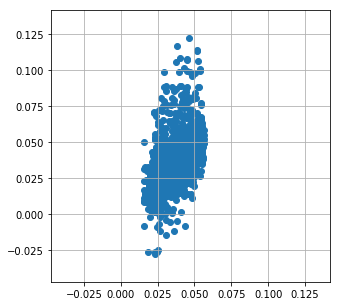

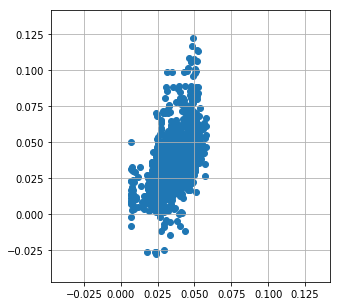

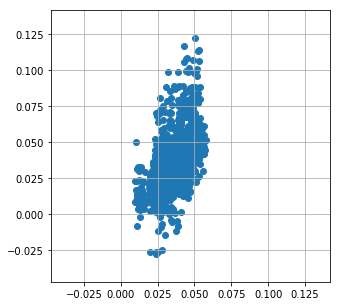

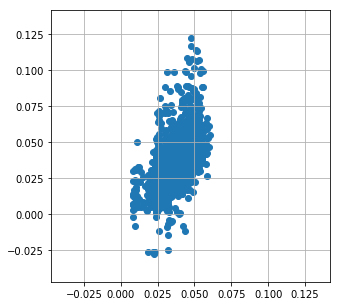

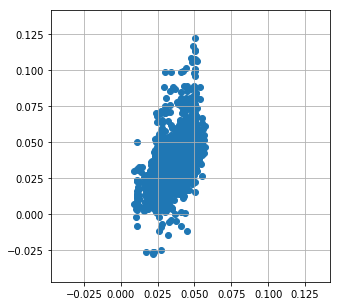

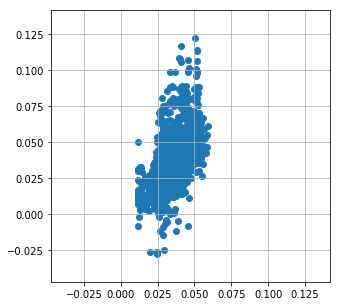

In [3]:
def TTV_Split(i,Memory,X,y,params):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(LSTM.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,y_val,i,X_fill = X,Memory=Memory))


Full = ['H','LE','Fco2','fco2','fch4','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table','Ts 2.5 cm',
         'Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']

Model = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Ts 2.5 cm','Ts 15 cm',
         'VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']


# Model = ['Water Table']

# Model = [' Active Layer','H']

Time = time.time()

Path = 'FilteredData2018-04-04.csv'


def RunReps(Model,Runs,params,pool = None):
    RST = RSTF.ReadStandardTimeFill(Path)#ReadStandardTime(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    RST.TimeShape(params['T'])
    y = RST.y_time*1.0
    X = RST.X_time*1.0
    MSE = []
    Y_fill = []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params),range(params['reps']))):
            mse = results[0]
            y_fill = results[1]
            Y_fill.append(y_fill)
            MSE.append(mse)
    else:
        for i in range(params['reps']):
            results = TTV_Split(i,Memory,X,y,params)
            mse = results[0]
            MSE.append(mse)
            y_fill = results[1]
            Y_fill.append(y_fill)
    MSE = np.asanyarray(MSE)
    Y_fill = np.asanyarray(Y_fill).mean(axis=0)#.mean(axis=0)
#     print(Y_fill.shape)
#     RST.Fill(Y_fill,'Fch4')
    y = RST.YScaled.inverse_transform(y)
    Y_fill = RST.YScaled.inverse_transform(Y_fill)
    
    plt.figure(figsize=(5,5))
    plt.scatter(Y_fill,y)
    yl = plt.ylim()
    plt.xlim(yl[0],yl[1])
    plt.grid()
#     print(metrics.r2_score(Y_fill,y))
    return(MSE)
    

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    

for i in Runs.index:
    params['T']=Runs['T'].iloc[i]
    params['N']=Runs['N'].iloc[i]
    MSE = RunReps(Model,Runs,params,pool)#RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    print('Finisehed Run ',str(i))
#     print(' Stats: ')
#     print(Runs.iloc[i])

Runs
  
print(time.time()-Time)
        

No handles with labels found to put in legend.


    N  T       MSE  STD
0  45  4  0.749780  0.0
1  84  7  0.818501  0.0
2  97  4  0.748351  0.0
3  87  7  0.805185  0.0
4  80  7  0.811221  0.0
5  61  6  0.964535  0.0


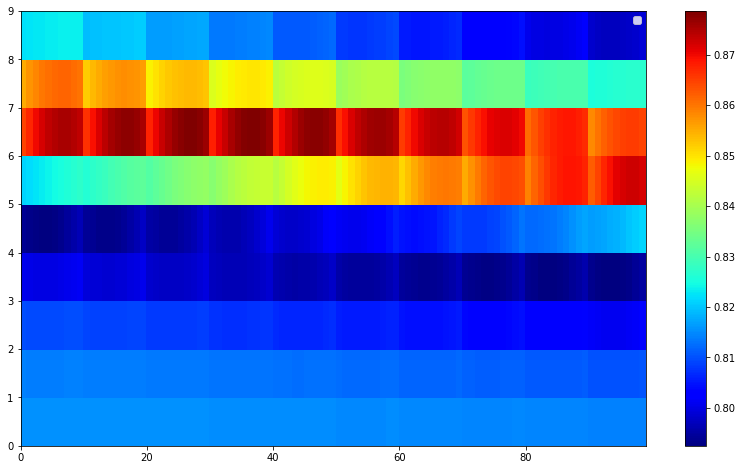

In [5]:
from scipy.stats import norm

plt.rcParams["figure.figsize"] = (14, 8)
def probability_of_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return norm.cdf(gamma_x)


def expected_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return sigma_x * (gamma_x * norm.cdf(gamma_x) + norm.pdf(gamma_x))


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

kernel = Matern(length_scale = [1,1],length_scale_bounds="fixed")
kernel = ConstantKernel(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
+ WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=0,normalize_y=True)
gp.fit(Runs[['N','T']].values, Runs['MSE'].values)

N = [n for n in range(params['N_Max'])]
T = [t for t in range(params['T_Max'])]
A = [T[i] for j in range(len(N))for i in range(len(T))]
B = [N[j] for j in range(len(N))for i in range(len(T))]
T = np.asanyarray(A)
N = np.asanyarray(B)

# print(T)
# print(N)


X = np.zeros(shape=(T.shape[0],2))
X[:,0] = N
X[:,1] = T

Xi = np.arange(N.min(),N.max()+.1,1)
Yi = np.arange(T.min(),T.max()+.1,1)
xi,yi = np.meshgrid(Xi,Yi)

# print(xi.shape,yi.shape)

# print(X)

y_pred,sigma = gp.predict(X,return_std=True)
y_predi = y_pred.reshape(xi.shape[0],xi.shape[1])

print(Runs)

plt.figure()
# plt.imshow(y_pred)
plt.pcolor(xi,yi,y_predi,cmap=cm.jet)
plt.colorbar()
# plt.scatter(X[:,0],X[:,1],c=y_pred)#[:,0],X[:,1],y_pred)
plt.legend()
Runs2 = Runs.copy()

[ 94.57705276   4.7107337 ]
95 5
[ 0.96461487]
[ 99.03147837   2.98421216]
99 3
[ 0.96498795]
        MSE   N  STD  T
0  0.749780  45  0.0  4
1  0.964535  61  0.0  6
2  0.811221  80  0.0  7
3  0.818501  84  0.0  7
4  0.805185  87  0.0  7
5  0.964615  95  0.0  5
6  0.748351  97  0.0  4
7  0.964988  99  0.0  3


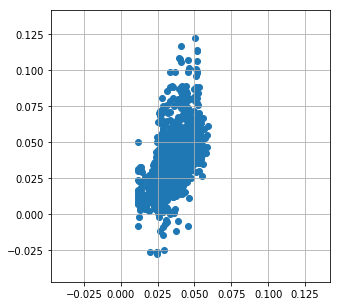

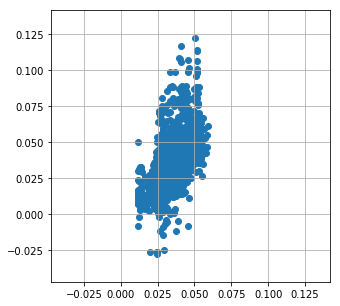

In [6]:
from scipy.optimize import minimize
acq = upper_confidence_bound
def query(xi, yi, gp):
    best_value = np.inf

    for N in np.linspace(1,params['N_Max']):
        for T in np.linspace(0,params['T_Max']):
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
#                 print(np.min(yi),np.max(yi))
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray([N,T]).reshape(1,2)
            res = minimize(obj, x0, bounds=((1, params['N_Max']),(0,params['T_Max'])))

            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point

for i in range(params['Searches']):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
    gp.fit(Runs[['N','T']].values, Runs['MSE'].values)
    
    next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
    print(next_x)
    N = int(np.round(next_x[0],0))
    T = int(np.round(next_x[1],0))
    o = 0
    while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
        print('Adjust!')
        o +=1
        N += int(o*np.cos(o*np.pi))
    print(N,T)
    d = {'N':N,'T':T,'MSE':0,'STD':0}
    idx = Runs.index[-1] + 1
    D2 = pd.DataFrame(data=d,index=[idx])
    Runs = Runs.append(D2)
    
    MSE = RunReps(Model,Runs,params,pool)#RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
    print(MSE)
    Runs['MSE'][idx]=MSE.mean()
    Runs['STD'][idx]=MSE.std()
    
    Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    
print(Runs)

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

        MSE   N  STD  T
6  0.748351  97  0.0  4


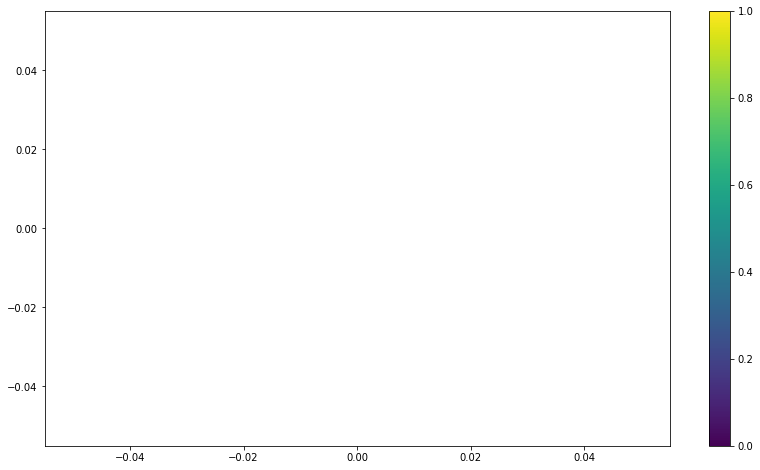

In [11]:
Optimum = Runs[Runs['MSE'] == Runs['MSE'].min()]
print(Optimum)
plt.figure()
plt.scatter(Runs["N"],Runs['T'],s=1/Runs['STD']*100,c=Runs['MSE'])
plt.colorbar()
# plt.legend()

['H']
['Wind Spd']
['air pressure']
['Ta']
['H']
['H'] 0.897520240354
['H', 'Wind Spd']
['H', 'air pressure']
['H', 'Ta']
['H', 'Wind Spd']
['H', 'Wind Spd'] 0.803623274679
['H', 'Wind Spd', 'air pressure']
['H', 'Wind Spd', 'Ta']
['H', 'Wind Spd', 'air pressure']
['H', 'Wind Spd', 'air pressure'] 0.798743152751
['H', 'Wind Spd', 'air pressure', 'Ta']
['H', 'Wind Spd', 'air pressure', 'Ta']
['H', 'Wind Spd', 'air pressure', 'Ta'] 0.788109889045


<Container object of 4 artists>

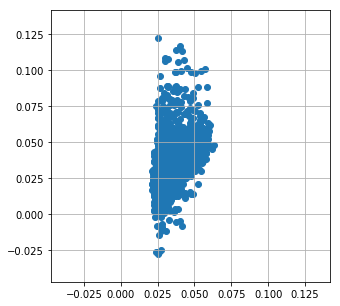

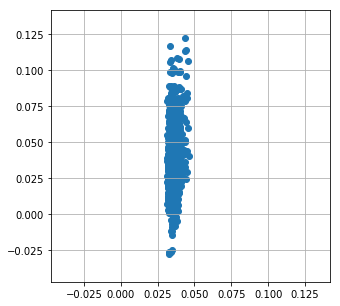

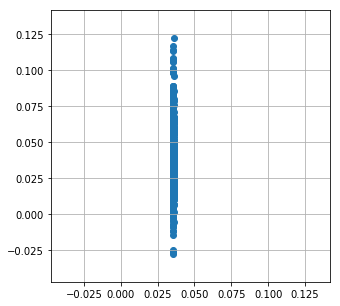

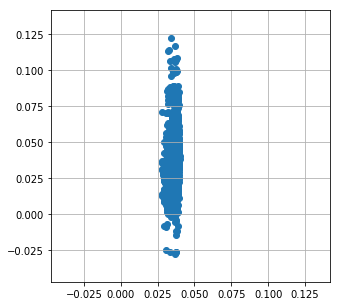

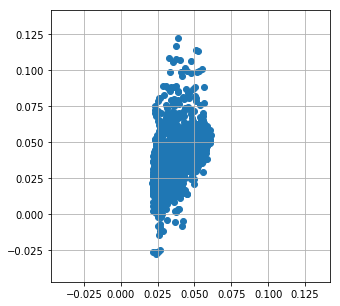

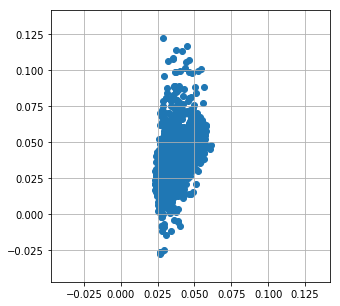

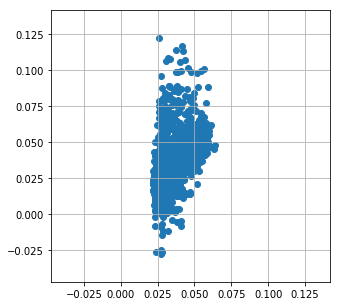

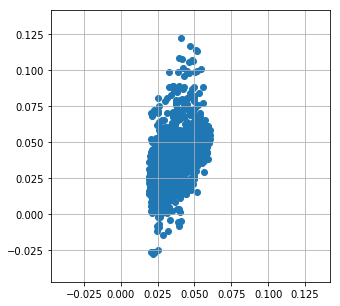

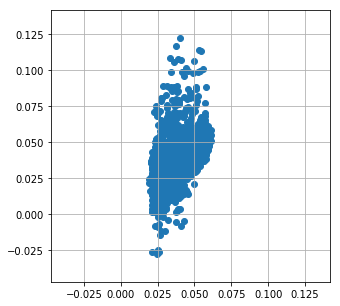

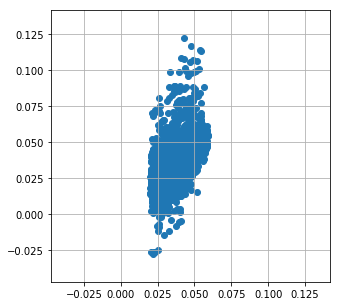

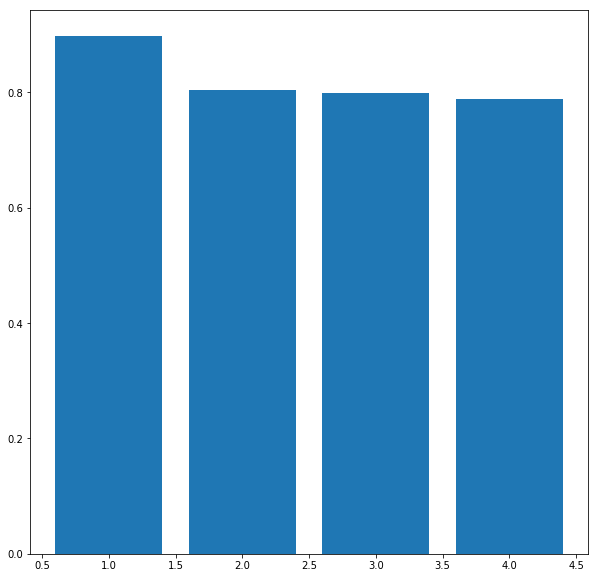

In [13]:
def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor == None:
            Models.append(c)
        else:
            if set(factor).issubset(set(c)):
#             if factor in c:
                Models.append(c)
    return(Models)
# print(params)
params['T']=Optimum['T'].values[0]
params['N']=Optimum['N'].values[0]
params['proc']=1
FullModel = ['H','Wind Spd','air pressure','Ta']#,
#          'Rn','PPFD','Ts 2.5 cm','Ts 15 cm',
#          'VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']


BestMSE = []
idx = []
BestModels = []

for i in range(1,len(FullModel)+1):
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
#     for model in Models:
    Score = []
    for model in Models:
        print(model)
        MSE = RunReps(model,Runs,params,pool)
        Score.append(MSE)
    Score = np.asanyarray(Score)
#         print(Score)
    print(Models[np.where(Score == Score.min())[0][0]])
    Best = Models[np.where(Score == Score.min())[0][0]]
    BestModels.append(Best)
    BestMSE.append(Score.min())
    idx.append(i)
    print('Best:')
    print(Best,Score.min())
BestModels = np.asanyarray(BestModels)
BestMSE = np.asanyarray(BestMSE)
idx = np.asanyarray(idx)
plt.figure(figsize=(10,10))
plt.bar(idx,BestMSE)